# Kelly Principle in Betting

https://www.researchgate.net/publication/312091638_Rational_Decision-Making_Under_Uncertainty_Observed_Betting_Patterns_on_a_Biased_Coin

You should always bet a constant fraction of your wealth in order to maximize the expected (log) of your wealth. This is known as the Kelly Principle.

The Kelly Principle finds an optimal fraction given by the formula:

$$
2*p - 1
$$

where $p$ is the probability of winning.

Let's simulate this in a biased coin toss. We will simulate a biased coin toss with a probability of winning of 0.6. We will simulate 1000 rounds of betting. We will bet a fraction of our wealth given by the Kelly Principle.

We'll look at 3 strategies:
* Betting a fixed amount of the initial wealth (10% and 25%)
* Betting a fixed amount of the current wealth (10% and 25%)
* Betting a fraction of the wealth given by the Kelly Principle

This simulation shows, yes, the Kelly Princple is optimal in the long run. But in practice the exact proportion you bet doesn't matter a lot. The important thing is to bet a constant fraction of your wealth. You're guaranteed to never go broke (as long as you can bet fractions of pennies). 

Never, ever bet a fixed amount of money! Note: this is what blinds are forcing you to: you have to bet a minimum amount of money, regardless of the odds. So they encourage you to go bankrupt.

In [2]:
import numpy as np
from abc import ABC, abstractmethod
from typing import Tuple, List
import matplotlib.pyplot as plt

class BettingStrategy(ABC):
    """Abstract base class for different betting strategies"""
    @abstractmethod
    def get_bet(self, bankroll: float, history: List[bool]) -> Tuple[float, bool]:
        """
        Returns (bet_amount, bet_on_heads)
        bet_amount: how much to bet
        bet_on_heads: True to bet on heads, False for tails
        """
        pass

class BiasedCoinGame:
    def __init__(self, 
                 initial_bankroll: float = 25.0,
                 win_threshold: float = 250.0,
                 heads_probability: float = 0.6):
        self.initial_bankroll = initial_bankroll
        self.win_threshold = win_threshold
        self.heads_probability = heads_probability
        
    def play_game(self, strategy: BettingStrategy) -> Tuple[float, int, bool]:
        """
        Plays one full game using the given strategy
        Returns: (final_bankroll, num_flips, won)
        """
        bankroll = self.initial_bankroll
        history = []
        num_flips = 0
        
        while 0 < bankroll < self.win_threshold:
            # Get bet from strategy
            bet_amount, bet_on_heads = strategy.get_bet(bankroll, history)
            bet_amount = min(bet_amount, bankroll)  # Can't bet more than you have
            
            # Flip coin
            is_heads = np.random.random() < self.heads_probability
            history.append(is_heads)
            num_flips += 1
            
            # Update bankroll
            won_bet = (is_heads == bet_on_heads)
            bankroll += bet_amount if won_bet else -bet_amount
            
        return bankroll, num_flips, bankroll >= self.win_threshold

# Example strategy: Always bet 10% on heads
class FixedPercentageStrategy(BettingStrategy):
    def __init__(self, percentage: float = 0.1):
        self.percentage = percentage
        
    def get_bet(self, bankroll: float, history: List[bool]) -> Tuple[float, bool]:
        return bankroll * self.percentage, True

class FixedAmountStrategy(BettingStrategy):
    def __init__(self, percentage: float = 0.1, initial_bankroll: float = 25.0):
        self.percentage = percentage
        self.initial_bankroll = initial_bankroll
        self.bet_amount = initial_bankroll * percentage
        
    def get_bet(self, bankroll: float, history: List[bool]) -> Tuple[float, bool]:
        return self.bet_amount, True  # Always bet fixed amount on heads




Running simulation for 10% wealth...
Win rate: 100.0%
Average number of flips: 157.1
Median final bankroll: $261.20

Running simulation for 25% wealth...
Win rate: 100.0%
Average number of flips: 123.9
Median final bankroll: $276.44

Running simulation for 10% initial wealth...
Win rate: 99.1%
Average number of flips: 442.7
Median final bankroll: $250.00

Running simulation for 25% initial wealth...
Win rate: 79.1%
Average number of flips: 137.5
Median final bankroll: $250.00

Running simulation for Kelly Criterion...
Win rate: 100.0%
Average number of flips: 124.0
Median final bankroll: $271.12


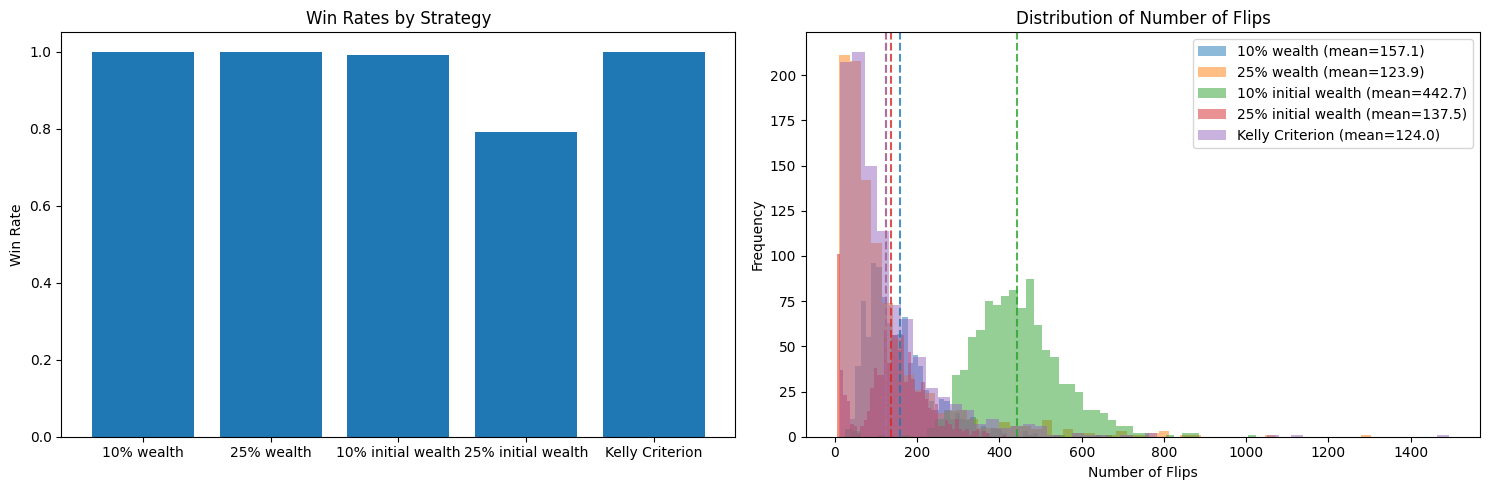

In [4]:
class KellyCriterionStrategy(BettingStrategy):
    def __init__(self, heads_probability: float = 0.6):
        self.heads_probability = heads_probability
        
    def get_bet(self, bankroll: float, history: List[bool]) -> Tuple[float, bool]:
        # Kelly Criterion formula: f* = (p*b - q)/b
        # where p = probability of winning, q = probability of losing
        # b = odds received (1 in this case)
        
        # Always bet on the favorable outcome (heads)
        p = self.heads_probability  # probability of heads
        q = 1 - p  # probability of tails
        b = 1  # even money odds
        
        kelly_fraction = (p*b - q)/b
        return bankroll * kelly_fraction, True

def run_simulation(game: BiasedCoinGame, strategy: BettingStrategy, num_games: int = 1000) -> List[Tuple]:
    """Run multiple games with the same strategy and return results"""
    results = []
    for _ in range(num_games):
        result = game.play_game(strategy)
        results.append(result)
    return results

def analyze_results(results: List[Tuple]):
    """Analyze and print summary statistics"""
    final_bankrolls, num_flips, won_games = zip(*results)
    win_rate = sum(won_games) / len(won_games)
    
    print(f"Win rate: {win_rate:.1%}")
    print(f"Average number of flips: {np.mean(num_flips):.1f}")
    print(f"Median final bankroll: ${np.median(final_bankrolls):.2f}")
    
def plot_comparison(strategies_results: dict):
    """Plot comparison of different strategies"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot win rates
    win_rates = {name: sum(won for _, _, won in results)/len(results) 
                 for name, results in strategies_results.items()}
    ax1.bar(win_rates.keys(), win_rates.values())
    ax1.set_title('Win Rates by Strategy')
    ax1.set_ylabel('Win Rate')
    
    # Plot distribution of number of flips
    for name, results in strategies_results.items():
        flips = [n for _, n, _ in results]
        mean_flips = np.mean(flips)
        
        # Plot histogram and mean line
        hist = ax2.hist(flips, alpha=0.5, label=f"{name} (mean={mean_flips:.1f})", bins=50)
        ax2.axvline(mean_flips, color=hist[2][0].get_facecolor(), 
                    linestyle='--', alpha=0.8)
    
    ax2.set_title('Distribution of Number of Flips')
    ax2.set_xlabel('Number of Flips')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    plt.tight_layout()
    return fig

# Run simulations
if __name__ == "__main__":
    game = BiasedCoinGame()
    strategies = {
        '10% wealth': FixedPercentageStrategy(0.1),
        '25% wealth': FixedPercentageStrategy(0.25),
        '10% initial wealth': FixedAmountStrategy(0.1, 25.0),
        '25% initial wealth': FixedAmountStrategy(0.25, 25.0),
        'Kelly Criterion': KellyCriterionStrategy(0.6)
    }
    
    results = {}
    for name, strategy in strategies.items():
        print(f"\nRunning simulation for {name}...")
        results[name] = run_simulation(game, strategy, num_games=1000)
        analyze_results(results[name])
    
    # Plot results
    plot_comparison(results)
    plt.show()